In [67]:
from pprint import pprint
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage
import tensorflow as tf
import keras
from tensorflow.python.framework import ops
#from cnn_utils import *
import os
os.environ['CUDA_VISIBLE_DEVICES']='-1'
import deepdish.io as io
from keras.models import Sequential
from keras.utils.np_utils import to_categorical
#from keras.models import Sequential, Model
#from keras.layers import Input, Dense, Dropout, LeakyReLU
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
from keras.wrappers.scikit_learn import KerasRegressor
#from keras.utils import multi_gpu_model
from keras.datasets import mnist
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from itertools import izip
import random

In [121]:
#Loading data
data_sig_A = io.load(os.path.join('MEM-A-dbsig.h5'))
data_sig_B = io.load(os.path.join('MEM-B-dbsig.h5'))
#data_sig_C = io.load(os.path.join('MEM-C-0500_unscaled_signal.h5'))
data_back_A = io.load(os.path.join('MEM-A-dbbkg.h5'))
data_back_B = io.load(os.path.join('MEM-B-dbbkg.h5'))
data_sig_B.keys()

['y', 'X', 'signal_lh']

In [122]:
#Assigning data
X_Big_train = data_sig_A['X']
target_BigSig_train = data_sig_A['signal_lh']
y_BigSig_train = data_sig_A['y']

X_forShuffle = data_sig_A['X']


X_Big_test = data_sig_B['X']
target_BigSig_test = data_sig_B['signal_lh']
y_BigSig_test = data_sig_B['y']

#X_Big_valid = data_sig_C['X']
#target_BigSig_valid = data_sig_C['signal_lh']
#y_BigSig_valid = data_sig_C['y']

target_BigBack_train = data_back_A['bkg_lh']
y_BigBack_train = data_back_A['y']
target_BigBack_test = data_back_B['bkg_lh']
y_BigBack_test = data_back_B['y']

sig_to_backRatio_train = target_BigSig_train/target_BigBack_train
sig_to_backRatio_test = target_BigSig_test/target_BigBack_test

softTarget_train= target_BigSig_train/(target_BigSig_train+(0.1*target_BigBack_train))
softTarget_test = target_BigSig_test/(target_BigSig_test+(0.1*target_BigBack_test))

#np.shape(y_BigSig_valid)
#print np.shape(target_BigSig_test)
#print np.shape(target_BigBack_test)
print np.shape(sig_to_backRatio_train)
print np.shape(sig_to_backRatio_test)
print target_BigBack_test.max()
print target_BigBack_test.min()

(520739,)
(173580,)
1.0765009091544848e-22
3.121791221788734e-48


In [126]:
####X_Big_train.shape[0] #size of row
####X_Big_train.shape[1] #size of column
####X_Big_train.shape[-1] #size of last dimension, here its collumn
####X_train_bjet = X_Big_train[:,:4] #take 1st 4 data of each collumn
####bet = X_train_bjet[:, ::-1] #flip the collum right to left
#X_train_bjet
#bet
#ix = np.argsort(X_forShuffle[:, :4])[:, ::-1]
ix = [random.sample(range(4), 4) for _ in xrange(X_forShuffle.shape[0])]
def _pairwise(iterable):
    a = iter(iterable)
    return izip(a, a)

cols = list(_pairwise(range(X_forShuffle.shape[-1])[::4]))

for slc in cols:
    print 'Shuffling columns {}'.format(slc)
    X_forShuffle[:, slice(*slc)] = np.array([row[sh] for row, sh in zip(X_forShuffle[:, slice(*slc)], ix)])

Shuffling columns (0, 4)
Shuffling columns (8, 12)
Shuffling columns (16, 20)
Shuffling columns (24, 28)


In [48]:
X_Big_train[0,:]

array([ 1.60053482e+02,  3.76157722e+01,  4.59020767e+01,  7.24027176e+01,
        7.05109100e+01,  1.05436775e+02,  3.29363976e+01,  1.24970154e+02,
        2.30744839e+00, -1.61757755e+00, -1.95439517e-01,  8.95875216e-01,
        2.47034168e+00,  2.29786325e+00,  4.11413014e-01, -2.68603772e-01,
       -2.50591546e-01, -2.64650035e+00, -1.11038613e+00,  2.85890651e+00,
        7.24493384e-01, -2.63377279e-01, -2.83341169e+00,  2.37839603e+00,
        8.12146274e+02,  9.86511089e+01,  4.70170272e+01,  1.03560374e+02,
        4.19929242e+02,  5.29997252e+02,  3.57633551e+01,  1.29505496e+02])

In [125]:
 X_Big_train[:,:4]

array([[ 78.3900528 , 130.50350952,  52.35677719, 117.82160187],
       [ 30.79380035,  53.16017914,  62.00756836,  56.99935913],
       [ 66.41336823,  81.34860229, 195.1685791 ,  66.80712128],
       ...,
       [126.02894592,  43.05223083,  76.29724884,  52.33808899],
       [114.4548645 ,  52.8911171 ,  38.78549194,  96.76007843],
       [ 56.63290787,  54.83947372,  41.37168503,  39.91780472]])

In [53]:
X_forShuffle[0,:]

array([ 3.76157722e+01,  4.59020767e+01,  1.60053482e+02,  7.24027176e+01,
        7.05109100e+01,  1.05436775e+02,  3.29363976e+01,  1.24970154e+02,
       -1.61757755e+00, -1.95439517e-01,  2.30744839e+00,  8.95875216e-01,
        2.47034168e+00,  2.29786325e+00,  4.11413014e-01, -2.68603772e-01,
       -2.64650035e+00, -1.11038613e+00, -2.50591546e-01,  2.85890651e+00,
        7.24493384e-01, -2.63377279e-01, -2.83341169e+00,  2.37839603e+00,
        9.86511089e+01,  4.70170272e+01,  8.12146274e+02,  1.03560374e+02,
        4.19929242e+02,  5.29997252e+02,  3.57633551e+01,  1.29505496e+02])

In [127]:
X_forShuffle[:,:4]

array([[117.82160187,  52.35677719, 130.50350952,  78.3900528 ],
       [ 62.00756836,  30.79380035,  56.99935913,  53.16017914],
       [ 66.80712128,  66.41336823,  81.34860229, 195.1685791 ],
       ...,
       [ 76.29724884,  52.33808899, 126.02894592,  43.05223083],
       [ 96.76007843,  52.8911171 , 114.4548645 ,  38.78549194],
       [ 56.63290787,  41.37168503,  54.83947372,  39.91780472]])

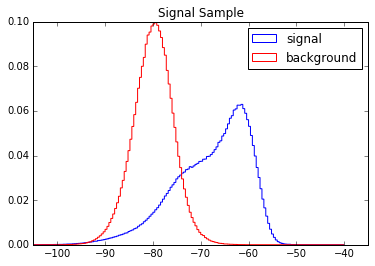

In [9]:
_=plt.hist(target_BigSig_train[np.where(y_BigSig_train==1)],bins=200,range=(-120,-40),  histtype='step', label='signal',normed = 1)
_=plt.hist(target_BigSig_train[np.where(y_BigSig_train==0)],bins=200,range=(-120,-40), histtype='step', color= 'red', label='background',normed = 1)
_=plt.title('Signal Sample')
_=plt.legend(loc='best')
_=plt.xlim([-105, -35])

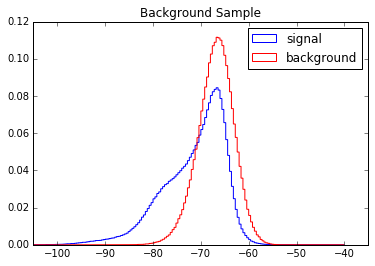

In [10]:
_=plt.hist(target_BigBack_train[np.where(y_BigBack_train==1)],bins=200,range=(-120,-40),  histtype='step', label='signal',normed =1)
_=plt.hist(target_BigBack_train[np.where(y_BigBack_train==0)],bins=200,range=(-120,-40), histtype='step', color= 'red', label='background',normed= 1)
_=plt.title('Background Sample')
_=plt.legend(loc='best')
_=plt.xlim([-105, -35])

area_sig
1.0
area_bkg
1.0
sig_events
90674
bkg_events
60775


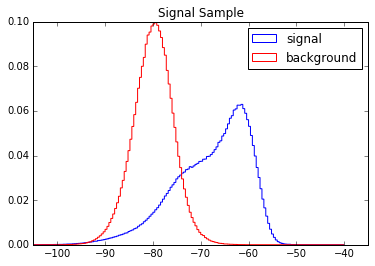

In [14]:
values_sig, bins_sig, _=plt.hist(target_BigSig_train[np.where(y_BigSig_train==1)],bins=200,range=(-120,-40), histtype='step', label='signal',normed = 1)
values_bkg, bins_bkg, _=plt.hist(target_BigSig_train[np.where(y_BigSig_train==0)],bins=200,range=(-120,-40), histtype='step', color= 'red', label='background',normed = 1)
_=plt.title('Signal Sample')
_=plt.legend(loc='best')
_=plt.xlim([-105, -35])

area_bkg= sum(np.diff(bins_bkg)*values_bkg)
bkg=np.where(y_BigSig_test==0)[0]
bkg_events = bkg.shape[0]

area_sig= sum(np.diff(bins_sig)*values_sig)
sig=np.where(y_BigSig_test==1)[0]
sig_events = sig.shape[0]

print 'area_sig' 
print area_sig

print 'area_bkg' 
print area_bkg

print 'sig_events' 
print sig_events

print 'bkg_events' 
print bkg_events

#area
#y_BigSig_test.shape[0]
#target_BigSig_test.shape[0]
#np.diff(bins)

area_sig
1.0
area_bkg
1.0
sig_events
90546
bkg_events
60903


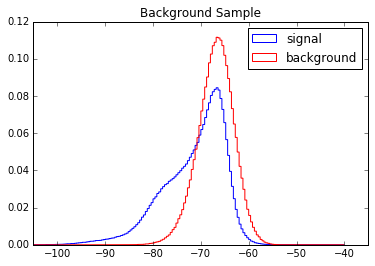

In [15]:
values_sig, bins_sig, _=plt.hist(target_BigBack_train[np.where(y_BigBack_train==1)],bins=200,range=(-120,-40), histtype='step', label='signal',normed = 1)
values_bkg, bins_bkg, _=plt.hist(target_BigBack_train[np.where(y_BigBack_train==0)],bins=200,range=(-120,-40), histtype='step', color= 'red', label='background',normed = 1)
_=plt.title('Background Sample')
_=plt.legend(loc='best')
_=plt.xlim([-105, -35])

area_bkg= sum(np.diff(bins_bkg)*values_bkg)
bkg=np.where(y_BigBack_test==0)[0]
bkg_events = bkg.shape[0]

area_sig= sum(np.diff(bins_sig)*values_sig)
sig=np.where(y_BigBack_test==1)[0]
sig_events = sig.shape[0]

print 'area_sig' 
print area_sig

print 'area_bkg' 
print area_bkg

print 'sig_events' 
print sig_events

print 'bkg_events' 
print bkg_events

60903

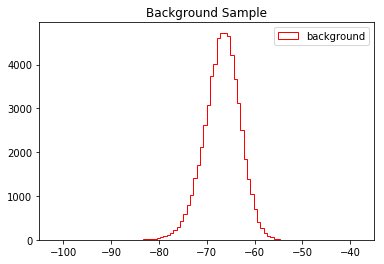

In [15]:
#_=plt.hist(target_BigBack_test[np.where(y_BigSig_test==1)],bins=100, histtype='step', label='signal')
values, bins, _=plt.hist(target_BigBack_test[np.where(y_BigBack_test==0)],bins=100, range=(-105,-35), histtype='step', color= 'red', label='background')
_=plt.title('Background Sample')
_=plt.legend(loc='best')
_=plt.xlim([-105, -35])

area = sum(np.diff(bins)*values)
#area
sti=sig_true_i=np.where(y_BigBack_test==0)[0]
sti.shape[0]
#np.diff(bins)

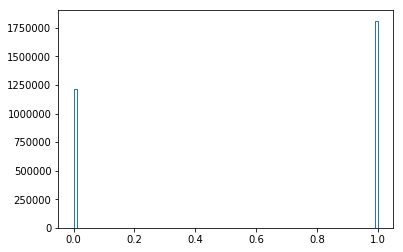

In [9]:
_=plt.hist(y_BigSig_train, bins=100, histtype='step', label='signal')
#_=plt.yscale('log')

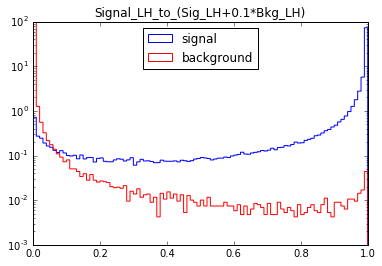

In [7]:
#_=plt.hist(target_BigSig_test[np.where(y_BigSig_test==1)],bins=100, histtype='step', label=' signal llh')
                           
#_=plt.hist(target_BigSig_test[np.where(y_BigSig_test==0)],bins=100, histtype='step', color= 'red')

_=plt.hist(softTarget_train[np.where(y_BigSig_train==1)],bins=100, histtype='step', label='signal', normed =1)
                           
_=plt.hist(softTarget_train[np.where(y_BigSig_train==0)],bins=100, histtype='step', color= 'red', label='background', normed=1)

#_=plt.xlim([1,0.8])

_=plt.yscale('log')

_=plt.legend(loc='upper center')

_=plt.title('Signal_LH_to_(Sig_LH+0.1*Bkg_LH)')

#_=plt.hist(sig_to_backRatio_train,bins=100, histtype='step')

#plt.legend(['training', 'validation'], loc='upper right')
#_=plt.hist(target_BigSig_test,bins=100)
#_=plt.hist(target_BigBack_test,bins=100)

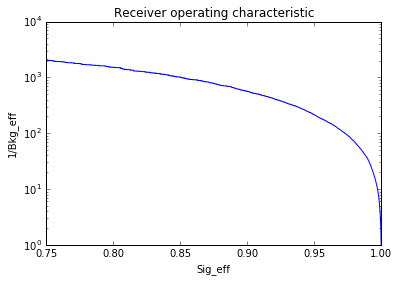

In [11]:
fpr_MEM, tpr_MEM, thresholds_MEM = roc_curve(y_BigSig_train,softTarget_train)
plt.figure()
##plt.plot(fpr, tpr)
plt.plot(tpr_MEM, 1/fpr_MEM)
plt.xlim([0.75, 1])
plt.ylim([1, 10000])
plt.yscale('log')
plt.ylabel('1/Bkg_eff')
plt.xlabel('Sig_eff')
plt.title('Receiver operating characteristic')
plt.show()

In [44]:
#Defining Sequential Model
def sequential_model():
    seqModel = models.Sequential()
    seqModel.add(Dense(32, input_dim=32, init='glorot_normal', activation='relu'))
    seqModel.add(Dense(12, init='glorot_normal', activation='relu'))
    seqModel.add(Dense(1, init='glorot_normal', activation='sigmoid'))
    seqModel.compile(loss='binary_crossentropy', optimizer='adam')
    return seqModel

In [128]:
sc_X = StandardScaler()
X_train1 = sc_X.fit_transform(X_forShuffle)
X_test1 = sc_X.fit_transform(X_Big_test)
#X_train1 = tf.keras.utils.normalize(X_Big_train)
#X_test1 = tf.keras.utils.normalize(X_Big_test)
#np.shape(y_BigSig_train)
model= tf.keras.models.Sequential()
#model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(32,input_dim=32, kernel_initializer='glorot_normal', activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(12,kernel_initializer='glorot_normal',activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(1,kernel_initializer='glorot_normal', activation=tf.nn.sigmoid))
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
model.fit(X_train1,y_BigSig_train, epochs=20, batch_size=256, verbose=2)
#model=sequential_model()
#model.fit(X_train1,y_BigSig_train, epochs=20, batch_size=256, verbose=2)
#model = Sequential()
#model.add(Dense(32, input_dim=32, activation='relu'))
#model.add(Dense(12,  activation='relu'))
#model.add(Dense(1,  activation='sigmoid'))
#model.compile(loss='categorical_crossentropy',optimizer='adam')
             
#model.fit(X_train1,y_BigSig_train, batch_size=256, verbose=1)

Epoch 1/20
 - 5s - loss: 0.2859 - acc: 0.8746
Epoch 2/20
 - 4s - loss: 0.2310 - acc: 0.9034
Epoch 3/20
 - 4s - loss: 0.2216 - acc: 0.9075
Epoch 4/20
 - 4s - loss: 0.2143 - acc: 0.9112
Epoch 5/20
 - 4s - loss: 0.2082 - acc: 0.9134
Epoch 6/20
 - 4s - loss: 0.2032 - acc: 0.9157
Epoch 7/20
 - 4s - loss: 0.1988 - acc: 0.9179
Epoch 8/20
 - 4s - loss: 0.1948 - acc: 0.9195
Epoch 9/20
 - 4s - loss: 0.1907 - acc: 0.9212
Epoch 10/20
 - 4s - loss: 0.1852 - acc: 0.9234
Epoch 11/20
 - 4s - loss: 0.1791 - acc: 0.9262
Epoch 12/20
 - 4s - loss: 0.1751 - acc: 0.9281
Epoch 13/20
 - 4s - loss: 0.1725 - acc: 0.9294
Epoch 14/20
 - 4s - loss: 0.1702 - acc: 0.9304
Epoch 15/20
 - 4s - loss: 0.1682 - acc: 0.9311
Epoch 16/20
 - 4s - loss: 0.1667 - acc: 0.9317
Epoch 17/20
 - 4s - loss: 0.1652 - acc: 0.9327
Epoch 18/20
 - 4s - loss: 0.1641 - acc: 0.9332
Epoch 19/20
 - 4s - loss: 0.1628 - acc: 0.9340
Epoch 20/20
 - 4s - loss: 0.1620 - acc: 0.9339


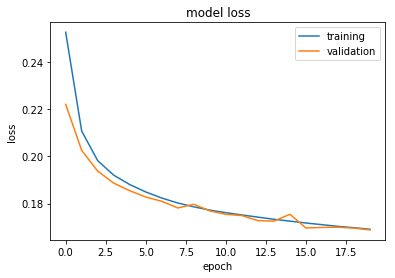

In [56]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [129]:
y_pred = model.predict(X_test1, verbose = True, batch_size=256)

173580/173580 [==============================] - 1s 5us/step


In [107]:
val_loss, val_acc = model.evaluate(X_test1, y_BigSig_test)
val_loss

173580/173580 [==============================] - 3s 19us/step


TypeError: 'numpy.float64' object is not iterable

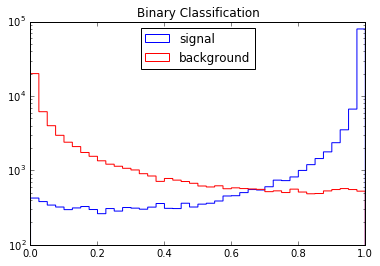

In [130]:
#_=plt.hist(y_pred, bins=50, histtype='step', label='signal')
_=plt.yscale('log')

_=plt.hist(y_pred[np.where(y_BigSig_test==1)],bins=40, histtype='step', label='signal')
                           
_=plt.hist(y_pred[np.where(y_BigSig_test==0)],bins=40, histtype='step', color= 'red', label='background')

#_=plt.xlim([0.50, 1.75])

_=plt.legend(loc='upper center')

_=plt.title('Binary Classification')

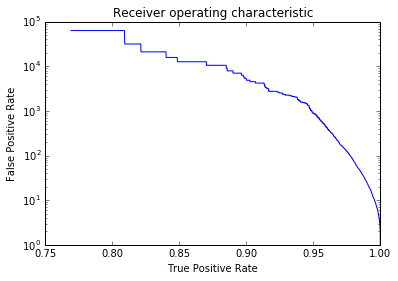

In [111]:
fpr_notOrdered, tpr_notOrdered, thresholds_notOrdered = roc_curve(y_BigSig_test,y_pred)
plt.figure()
#plt.plot(fpr, tpr)
plt.plot(tpr_notOrdered, 1/fpr_notOrdered)
plt.xlim([0.75, 1.0])
plt.yscale('log')
#plt.ylim([0.0, 1.05])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

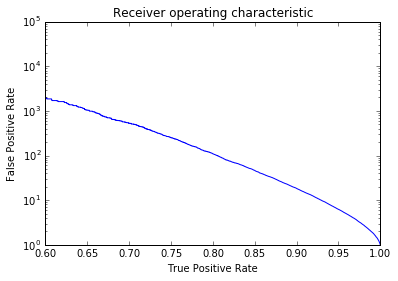

In [120]:
fpr_Ordered, tpr_Ordered, thresholds_Ordered = roc_curve(y_BigSig_test,y_pred)
plt.figure()
#plt.plot(fpr, tpr)
plt.plot(tpr_Ordered, 1/fpr_Ordered)
plt.xlim([0.6, 1.0])
plt.yscale('log')
#plt.ylim([0.0, 1.05])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

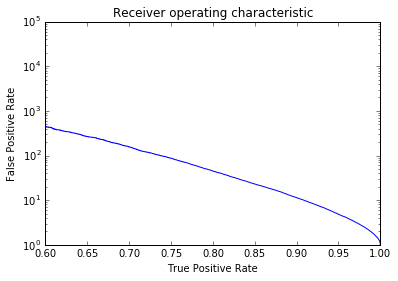

In [131]:
fpr_Shuffled, tpr_Shuffled, thresholds_Shuffled = roc_curve(y_BigSig_test,y_pred)
plt.figure()
#plt.plot(fpr, tpr)
plt.plot(tpr_Shuffled, 1/fpr_Shuffled)
plt.xlim([0.6, 1.0])
plt.yscale('log')
#plt.ylim([0.0, 1.05])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

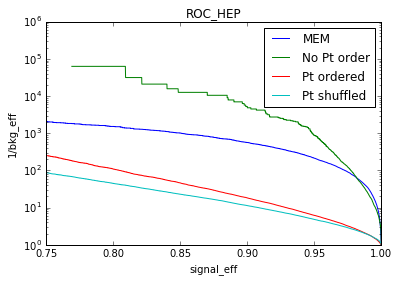

In [134]:
plt.plot(tpr_MEM,1/fpr_MEM, label='MEM')
plt.plot(tpr_notOrdered,1/fpr_notOrdered, label='No Pt order')
plt.plot(tpr_Ordered,1/fpr_Ordered, label='Pt ordered')
plt.plot(tpr_Shuffled,1/fpr_Shuffled, label='Pt shuffled')
#plt.plot(x, x**2, label='quadratic')
#plt.plot(x, x**3, label='cubic')
plt.xlim([0.75, 1.0])
plt.yscale('log')

plt.xlabel('signal_eff')
plt.ylabel('1/bkg_eff')

#plt.title("Simple Plot")
plt.title('ROC_HEP')

plt.legend(loc='upper right')

plt.show()

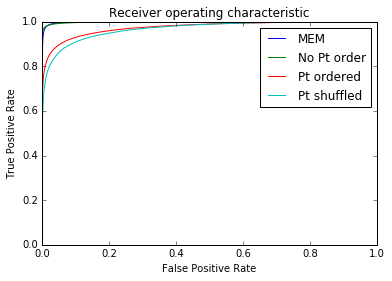

In [133]:
plt.plot(fpr_MEM,tpr_MEM, label='MEM')
plt.plot(fpr_notOrdered,tpr_notOrdered, label='No Pt order')
plt.plot(fpr_Ordered,tpr_Ordered, label='Pt ordered')
plt.plot(fpr_Shuffled, tpr_Shuffled, label='Pt shuffled')
#plt.plot(x, x**2, label='quadratic')
#plt.plot(x, x**3, label='cubic')
#plt.xlim([0.79, 1.0])
#plt.yscale('log')


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')

#plt.title("Simple Plot")

plt.legend()

plt.show()

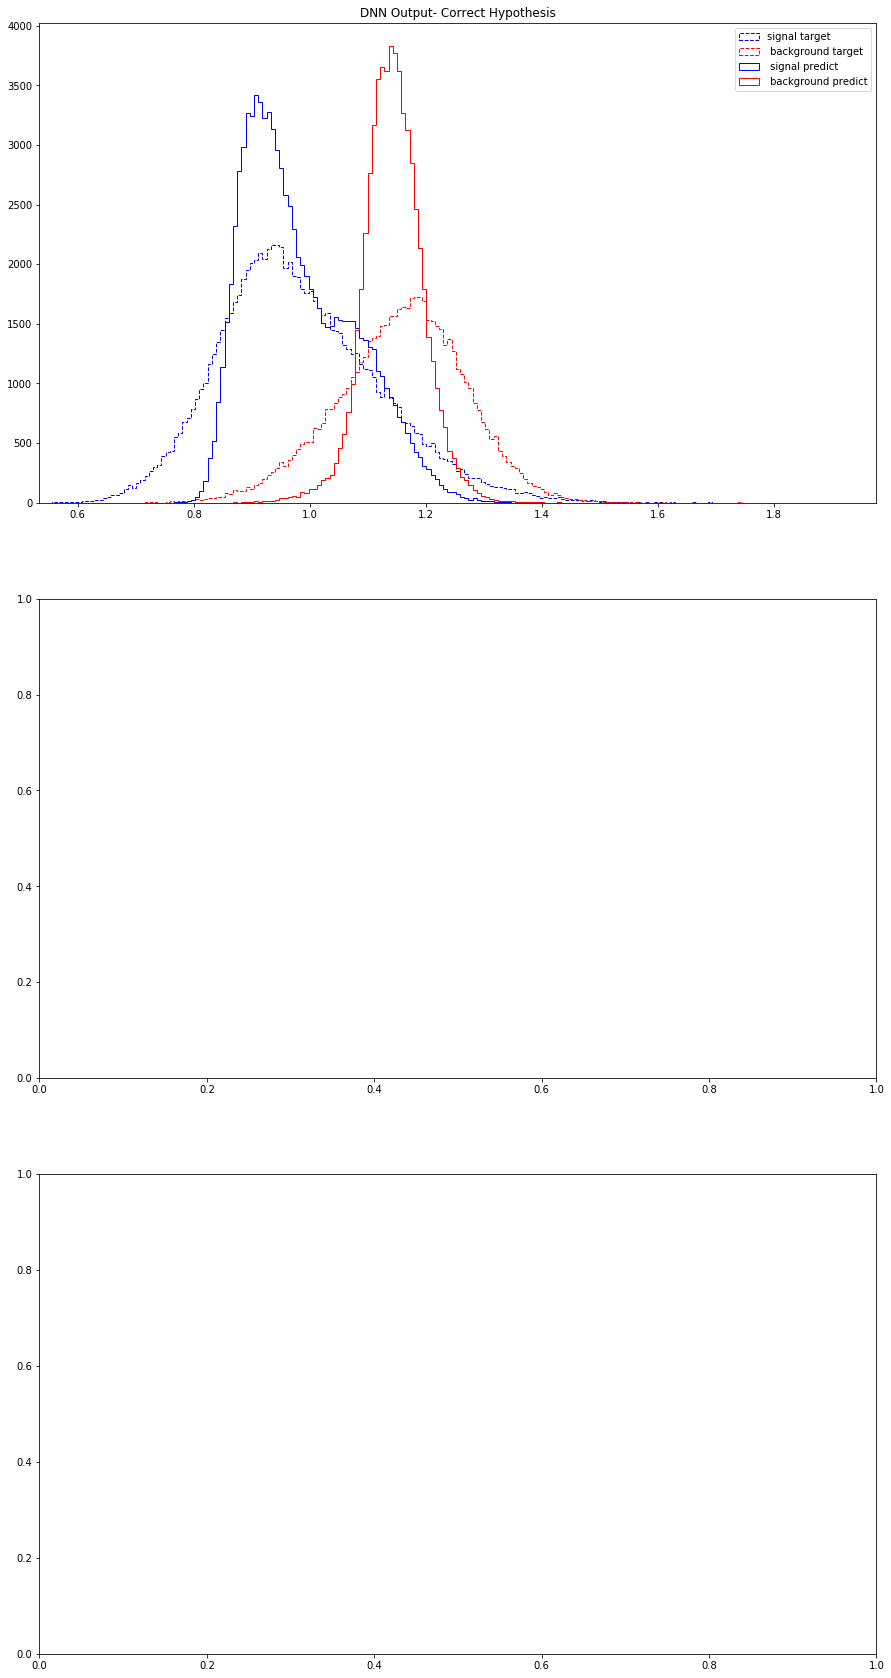

In [30]:
sti=sig_true_i=np.where(y_BigSig_test==1)[0]
bti=bkg_true_i=np.where(y_BigSig_test==0)[0]

n_datasets = 1
n_plots = 3
n_bins = 200
f1, axarr1 = plt.subplots(n_plots, n_datasets, sharex=False,
                            #gridspec_kw = {'height_ratios': [1,1,1,1]},
                            figsize=(15, 30),
                            squeeze=False)
plot_i1=0
plot_title="DNN Output- Correct Hypothesis"

min_out1=min(sig_to_backRatio_test.min(),seqResult.min())
max_out1=max(sig_to_backRatio_test.max(),seqResult.max())
bins_out1 = np.linspace(min_out1,max_out1,n_bins)
axarr1[plot_i1,0].set_xlim((min_out1,max_out1))
        
axarr1[plot_i1,0].hist(sig_to_backRatio_test[sti], color='blue', histtype='step', bins=bins_out1, linestyle='dashed', label='signal target')

axarr1[plot_i1,0].hist(sig_to_backRatio_test[bti], color='red', histtype='step', bins=bins_out1, linestyle='dashed', label=' background target')
axarr1[plot_i1,0].hist(seqResult[sti], color='blue', histtype='step', bins=bins_out1, linestyle='solid', label=' signal predict') 
axarr1[plot_i1,0].hist(seqResult[bti], color='red', histtype='step', bins=bins_out1, linestyle='solid', label=' background predict')
        
axarr1[plot_i1][0].set_title(plot_title)
axarr1[plot_i1][0].legend(loc='best', ncol=1)

x = np.linspace(0, 2, 100)

######################################
#plt.plot(x, x, label='linear')
#plt.plot(x, x**2, label='quadratic')
#plt.plot(x, x**3, label='cubic')

#plt.xlabel('x label')
#plt.ylabel('y label')

#plt.title("Simple Plot")

#plt.legend()

#plt.show()
######################################

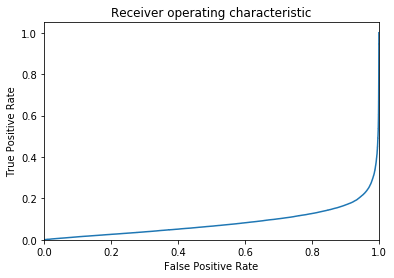

In [66]:
fpr, tpr, thresholds = roc_curve(y_BigSig_test,seqResult)
plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

In [63]:
y_BigSig_test

array([1, 1, 1, ..., 1, 1, 1])

In [64]:
seqResult

array([0.96143323, 1.0590225 , 0.8678651 , ..., 0.9105636 , 0.93391466,
       0.9763154 ], dtype=float32)

In [3]:
np.shape(data_sig_A['signal_llh'])

(3028985,)